[[ 665130.1772118  5101614.82683199]
 [ 665138.92759134 5101626.29131925]
 [ 665125.51339218 5101638.60648259]
 [ 665138.0756901  5101643.61333126]]
[ 596768.90198158 4433720.53683546]
[7.0710678118654755, 6.6332495807108005, 9.797958971132713, 9.38083151964686]
Receiver location: [46.048301660089855, 11.134480967115397]
[7.38817671 0.30275825 2.05869987 6.15233004]


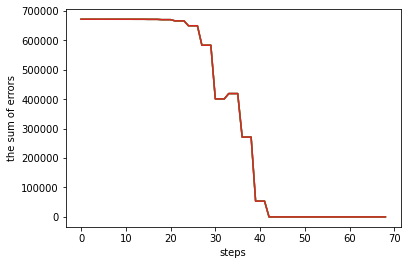

In [15]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyproj

errors_array = []

R = 6371000 # radius of the earth in meters

# GPS coordinates of the sources
source_locations = [
    (46.048174, 11.134445, 0),  # Source 1
    (46.048275, 11.134562, 0),  # Source 2
    (46.048389, 11.134393, 0),  # Source 3
    (46.048431, 11.134557, 0)  # Source 4
]
altitude = 10
zone = int((source_locations[0][1] + 180) / 6) + 1

# Distances from the receiver to the sources
d = np.array([7.5, 7.2, 9.8, 9.4])

# Convert GPS coordinates to Cartesian coordinates
# def to_cartesian(lat, lon, alt):
#     x, y, z = pyproj.Transformer.from_crs(4979, 4978, always_xy=True).transform(lon, lat, alt)
#     return x, y, z

def to_cartesian(lat, lon):
    # Calculate UTM zone from longitude
    zone = int((lon + 180) / 6) + 1
    # Determine if the point is in the Northern or Southern hemisphere
    hemisphere = 'north' if lat >= 0 else 'south'

    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs("epsg:4326", f"epsg:326{zone if lat >= 0 else zone + 100}")

    x, y = transformer.transform(lat, lon)
    return x, y

# Convert Cartesian coordinates to GPS coordinates
# def to_gps(x, y, z):
#     lon, lat, alt = pyproj.Transformer.from_crs(4978,4979, always_xy=True).transform(x, y, z)
#     return lat, lon, alt

def to_gps(x, y, zone, hemisphere):
    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs(f"epsg:326{zone if hemisphere == 'north' else zone + 100}", "epsg:4326")
    
    lat, lon = transformer.transform(x, y)
    return [lat, lon]

# Calculate the distance between the receiver and each source
def distance(xy_receiver, xy_source):
    return np.linalg.norm(xy_source - xy_receiver)

# Objective function to minimize the sum of squared errors between estimated and actual distances
def error(xy_receiver, xy_sources, d):
    distances = np.linalg.norm(xy_sources - xy_receiver, axis=1)
    errors = distances - d
    errors_array.append(np.sqrt(errors**2))
    return np.sum(errors**2)

# Define a function to convert radians to degrees
def degrees(rad):
    return rad * 180 / np.pi

# Starting GPS coordinates of the receiver (can be anywhere)
receiver_location = (40.048174, 10.134445, 0)

# Convert the GPS coordinates of the sources and the receiver to Cartesian coordinates
xy_sources = np.array([to_cartesian(lon, lat) for lon, lat, _ in source_locations])
xy_receiver = np.array(to_cartesian(*receiver_location[:2]))

print(xy_sources)
print(xy_receiver)

# Calculate the distance in 2d plane at the altitude
d_2d = []
for i in range(len(d)):
    alt_diff = np.abs(altitude - d[i])
    distance_2d = np.sqrt(d[i]**2-alt_diff**2)
    d_2d.append(distance_2d)
print(d_2d)

# Perform multilateration to estimate the location of the receiver
result = minimize(error, xy_receiver, args=(xy_sources, d_2d))
xy_receiver_estimated = result.x

# Convert the estimated Cartesian coordinates of the receiver back to GPS coordinates
receiver_location_estimated = to_gps(*xy_receiver_estimated, zone, 'north')

print('Receiver location:', receiver_location_estimated)


# # Plot the sources and the estimated location of the receiver
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the sources
# for i in range(len(source_locations)):
#     x, y, z = to_cartesian(*source_locations[i])
#     ax.scatter(x, y, z, color='r', marker='^')

# # Plot the estimated location of the receiver
# x, y, z = to_cartesian(*receiver_location_estimated)
# ax.scatter(x, y, z, color='b', marker='o')

# # Set the labels and title
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Multilateration')

# print(source_locations)
# # Plot circles (or spheres) representing the distance from each source
# for i in range(len(source_locations)):
#     # Calculate the radius of the circle (or sphere) in meters
#     radius = d[i]
#     # Get the Cartesian coordinates of the source
#     x, y, z = to_cartesian(*source_locations[i])
#     # Create a grid of points on the surface of the sphere
#     # Sphere in 3D
#     u = np.linspace(0, 2*np.pi, 100)
#     v = np.linspace(0, np.pi, 100)
#     X = x + radius*np.outer(np.cos(u), np.sin(v))
#     Y = y + radius*np.outer(np.sin(u), np.sin(v))
#     Z = z + radius*np.outer(np.ones_like(u), np.cos(v))
#     ax.plot_surface(X, Y, Z, color='r', alpha=0.2)

# plt.show()

# create a figure for error
fig = plt.figure()

plt.plot(errors_array)
plt.xlabel("steps")
plt.ylabel("the sum of errors")
print(errors_array[-1])

# show the plot
plt.show()

import folium

# Plot the sources and the estimated location of the receiver on a 2D map
m = folium.Map(location=receiver_location_estimated[:2], zoom_start=18, max_zoom=20)

# Plot the sources
for i in range(len(source_locations)):
    folium.Marker(location=source_locations[i][:2]).add_to(m)

# Plot the estimated location of the receiver
folium.Marker(location=receiver_location_estimated[:2], icon=folium.Icon(color='blue')).add_to(m)

# Plot circles representing the distance from each source
for i in range(len(source_locations)):
    # Calculate the radius of the circle in meters
    radius = d[i]
    # Get the location of the source
    source_location = source_locations[i][:2]
    # Draw the circle on the map
    folium.Circle(location=source_location, radius=radius, color='red', fill=False).add_to(m)

m



In [ ]:
import pyproj
print(pyproj.Transformer.from_crs(4979, 4978, always_xy=True).transform(11.134445, 46.048174, 0))
print(pyproj.Transformer.from_crs(4979, 4978, always_xy=True).transform(0, 90, 0))

# Using 0 as in this example corresponds to WGS84 sea level.

(4350995.655244533, 856348.1388868631, 4568965.557077716)
(3.9186209248144716e-10, 0.0, 6356752.314245179)


In [5]:
def foo(x):
    return x * 2  # replace with your own function

lst = [(1,2,3),(4,5,6)]
result = [[foo(x) for x in sub_lst[:2]] for sub_lst in lst]

print(result)  # prints: [[2, 4], [8, 10]]

[[2, 4], [8, 10]]
